## NaI Array Calibration

In [1]:
# Import libraries

import matplotlib.pyplot as plt
import numpy as np
import uproot
import os
import hist
from hist import Hist
from tabulate import tabulate


In [2]:
# Define function for plotting histograms

def PlotHist(name,data):

    fig, ax = plt.subplots(figsize=(8, 5))

    title = "Detector " + name[3:5]

    data.plot()

    ax.set_title(title)
    ax.set_xlabel("ADC Channel")
    ax.set_ylabel("Energy")
    ax.set_xlim([0,450])
    
    plt.show()
    

### Calibrate to Background

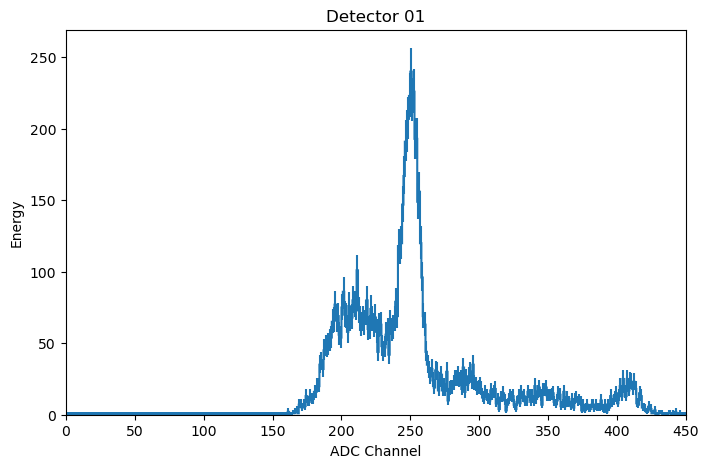

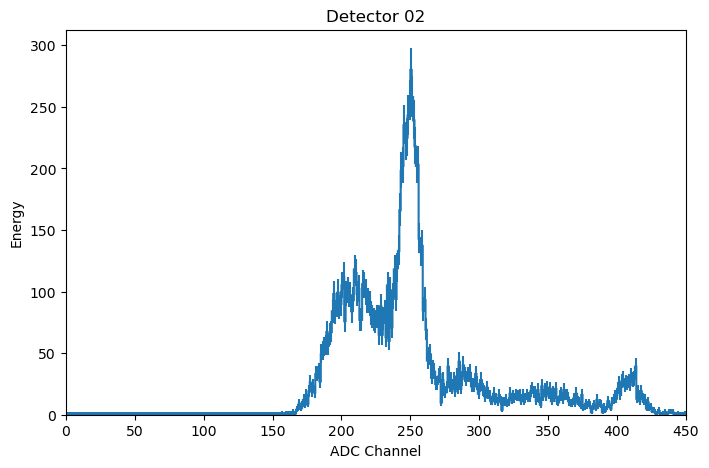

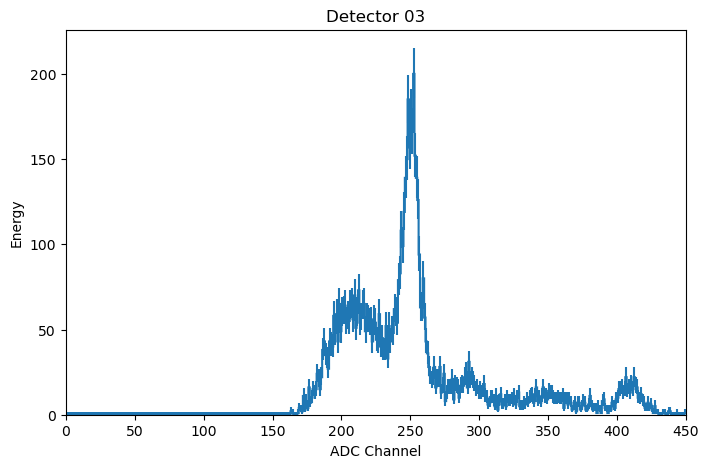

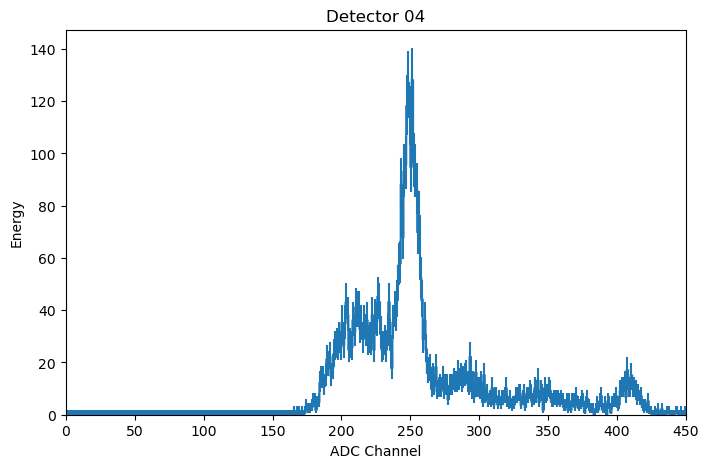

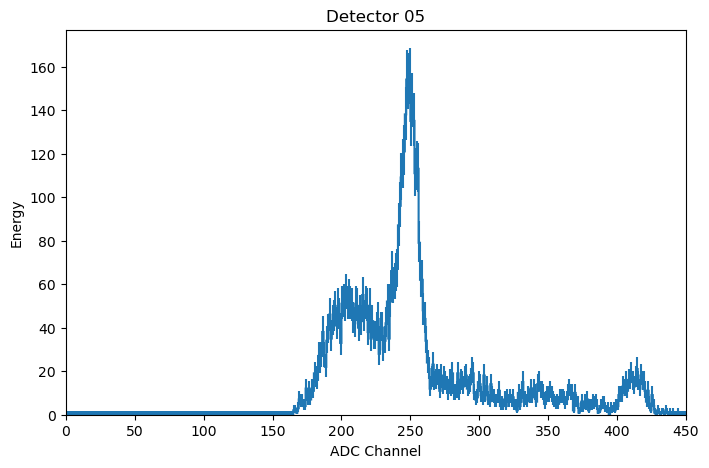

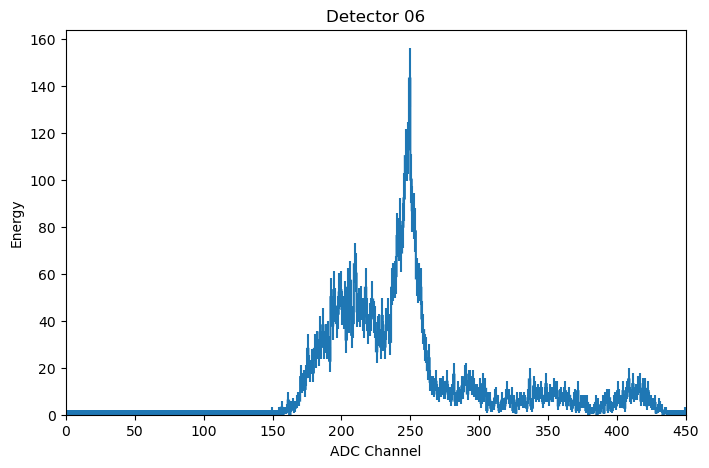

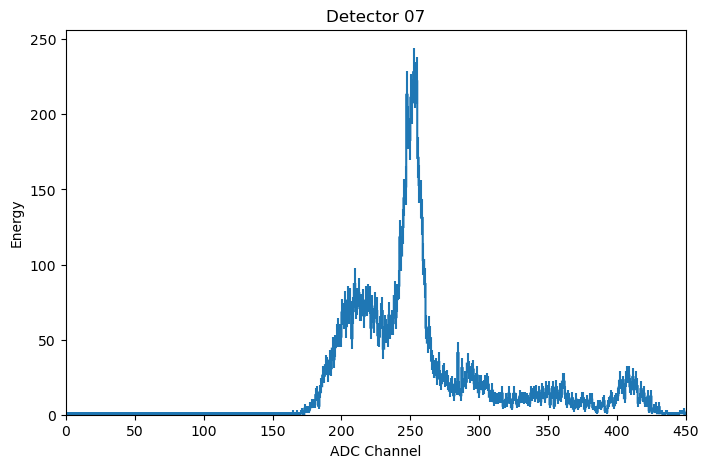

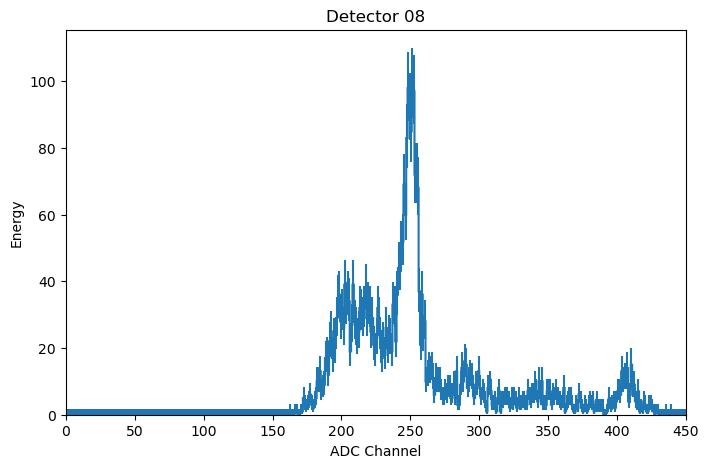

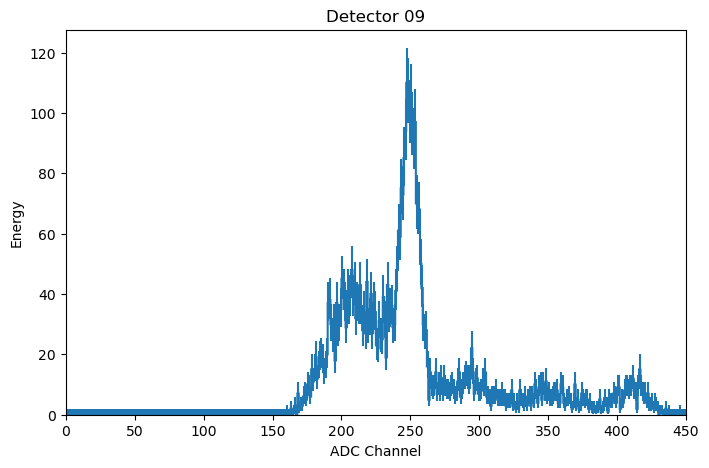

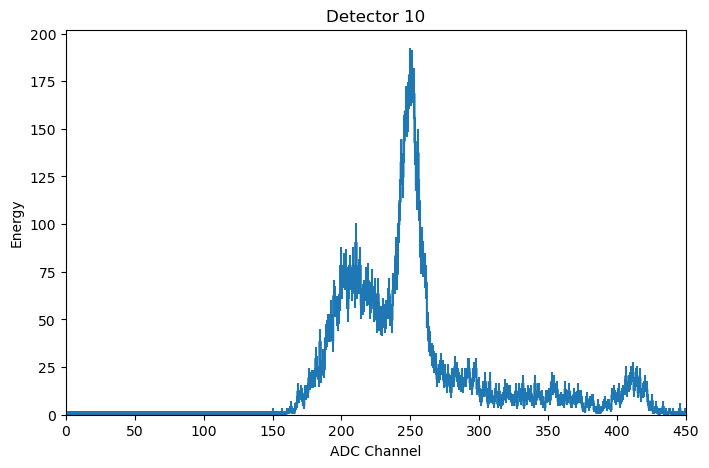

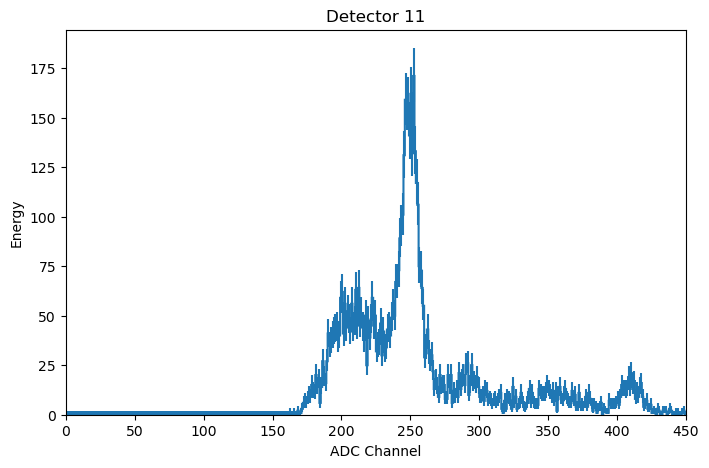

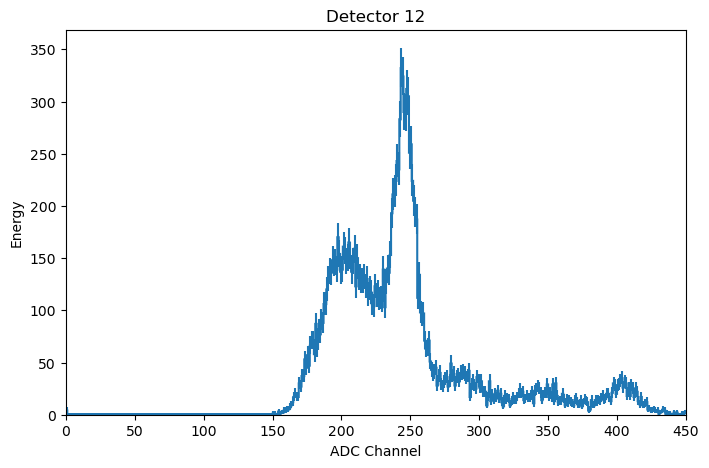

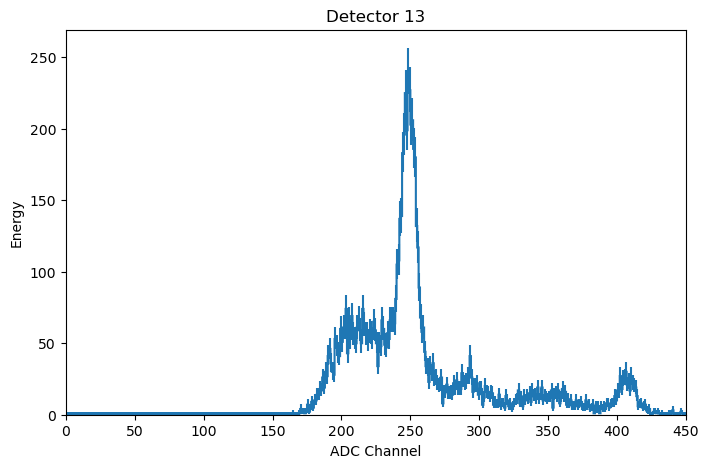

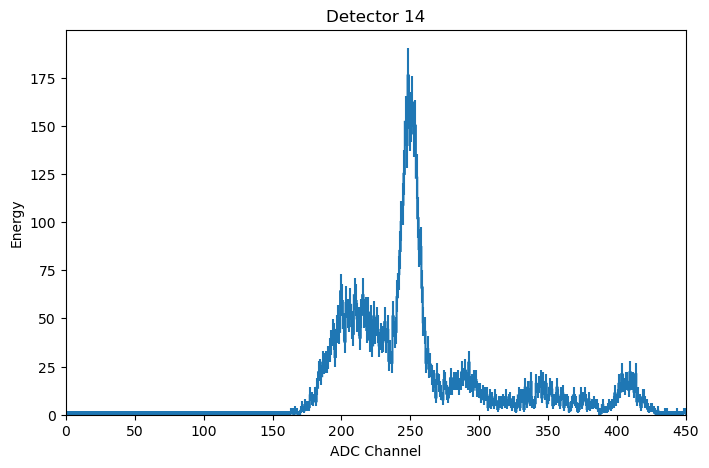

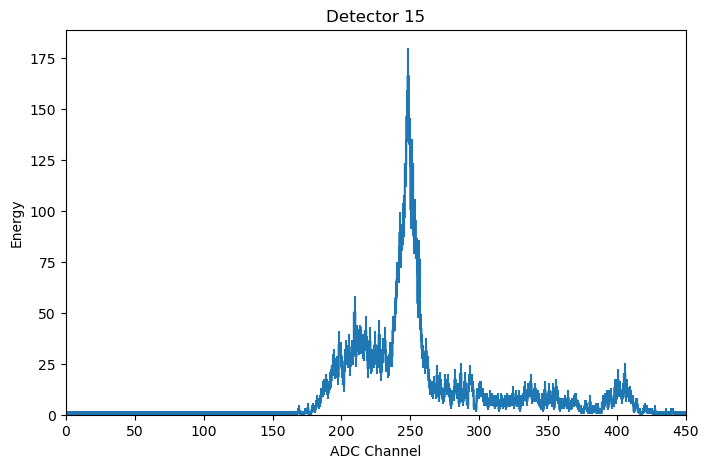

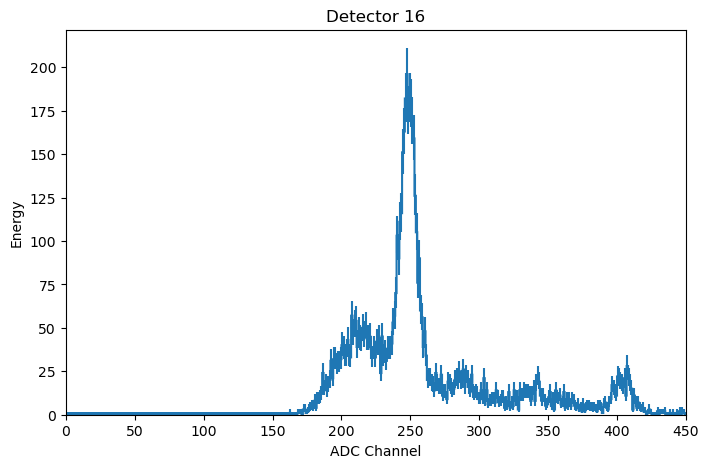

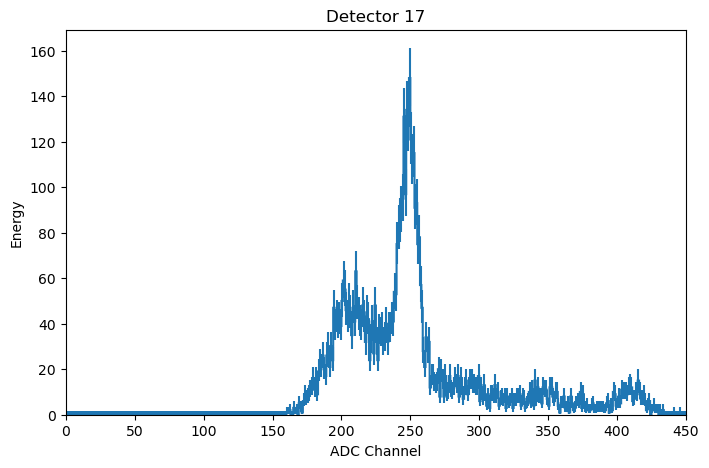

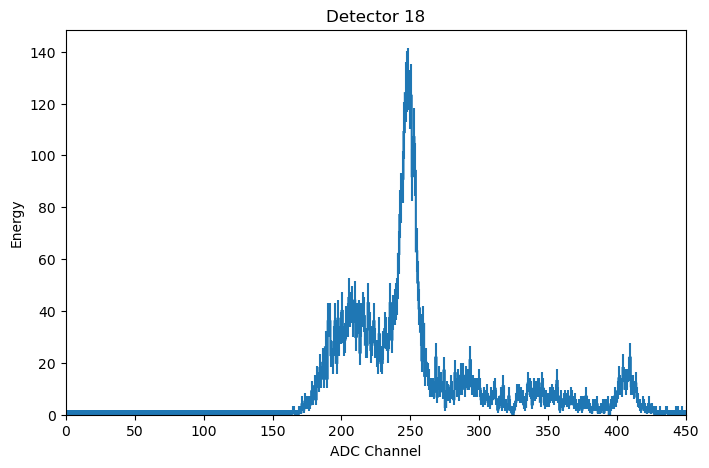

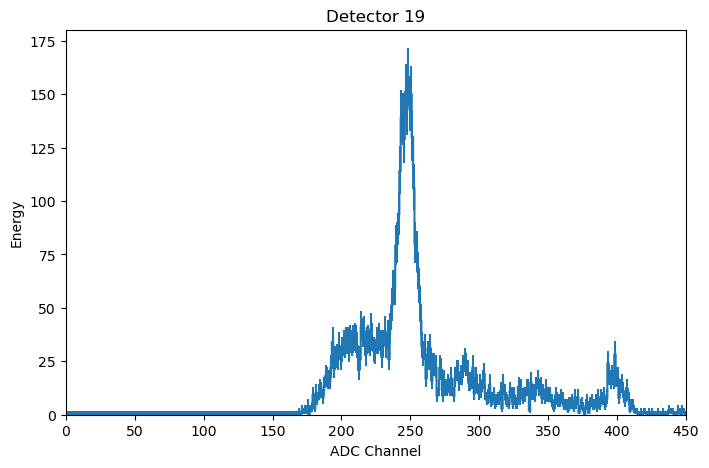

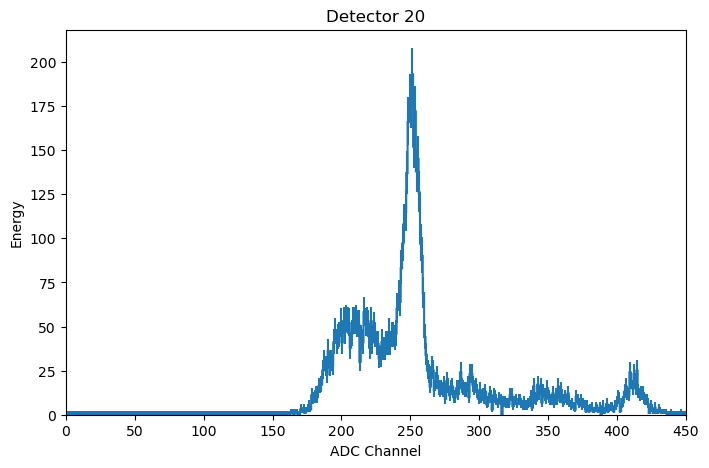

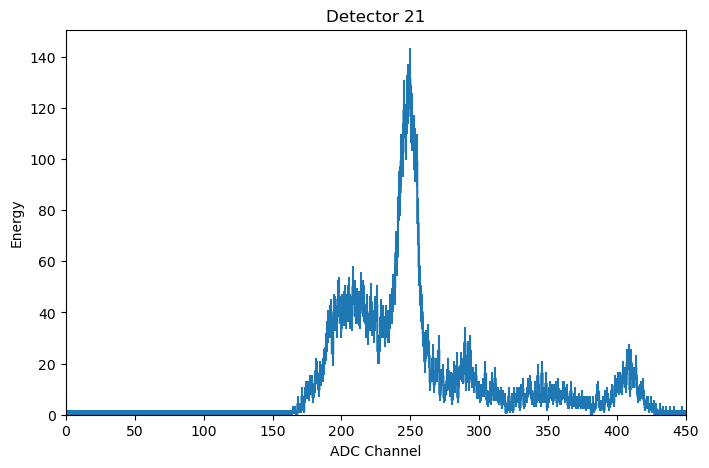

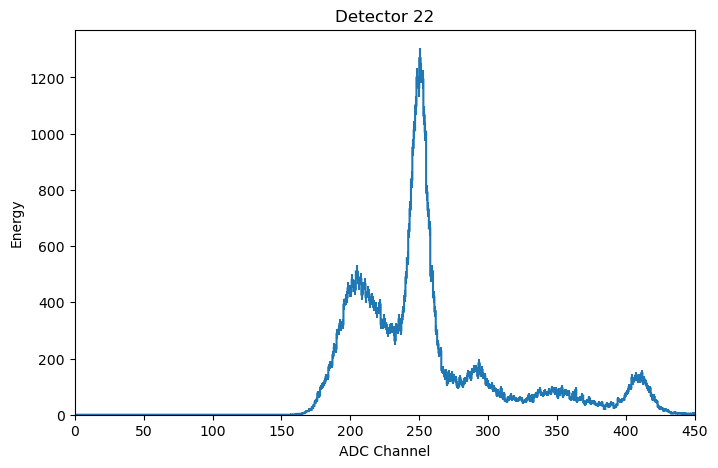

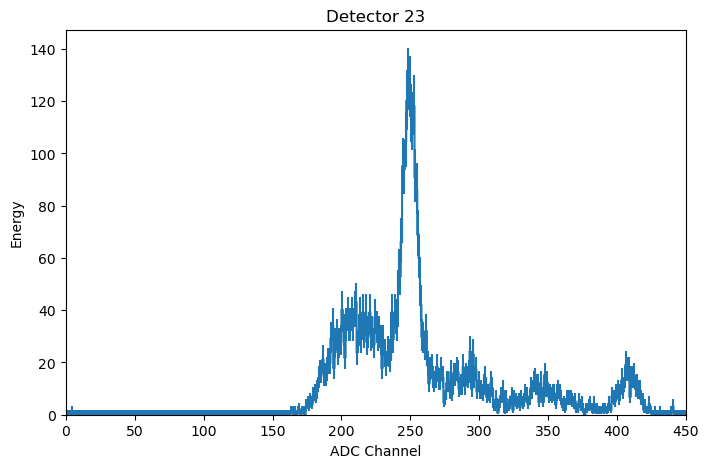

In [3]:
# Read in data from ROOT files and plot

directory = os.fsencode("Bknd_Calibration")
    
for file in os.listdir(directory):
    
    filename = os.fsdecode(file)
    datafile = "Bknd_Calibration/" + filename
    
    with uproot.open(datafile) as file:

        #print(file.keys())
        bknd = file["Energy/_F_EnergyCH0@DT5751_626"]
        bkndData = bknd.to_hist()
        
        PlotHist(filename,bkndData)
    

### Calibrate to Na-22 Source

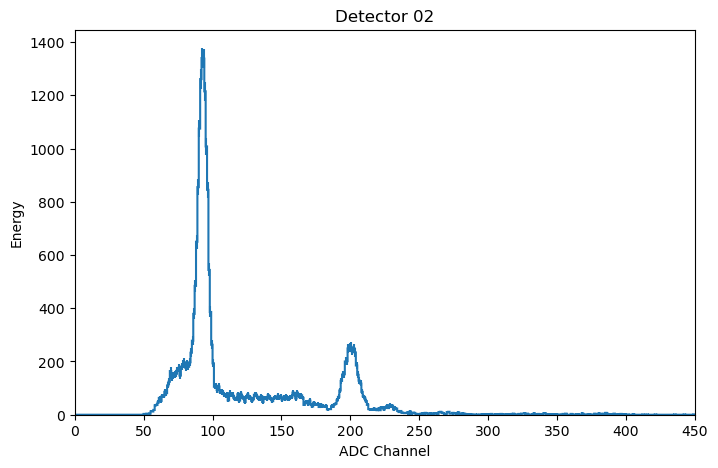

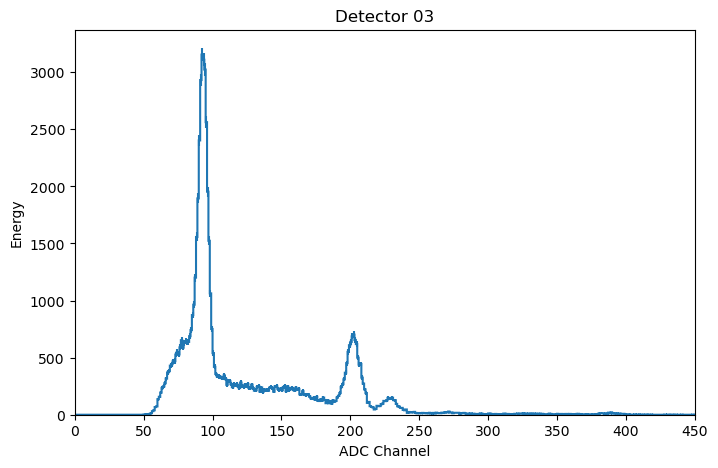

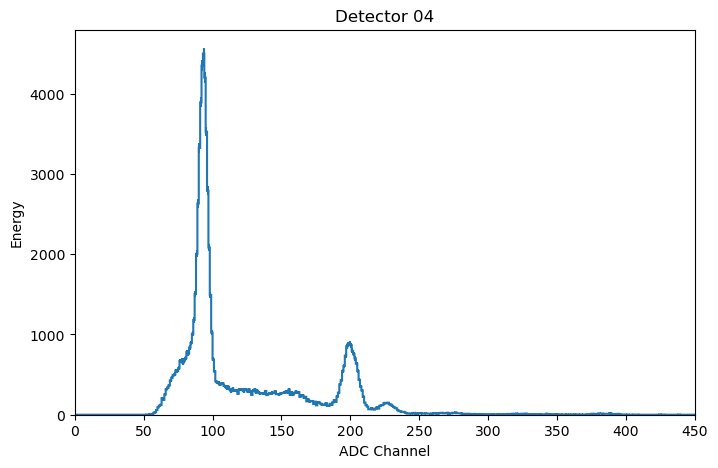

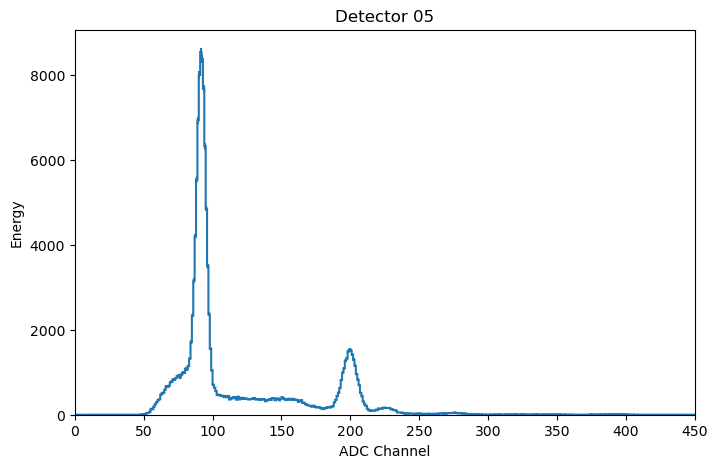

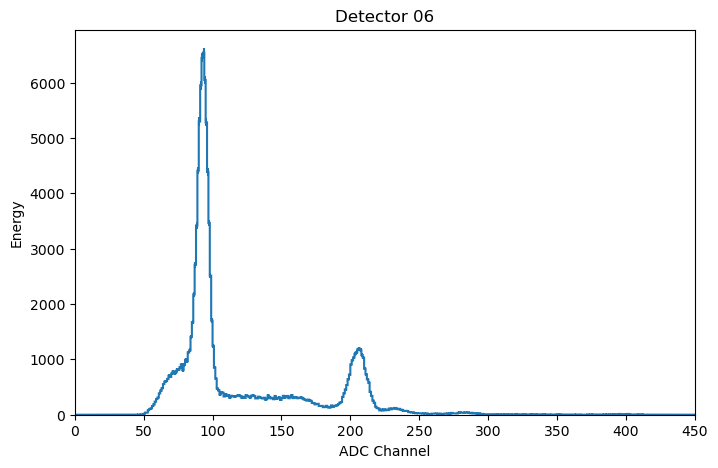

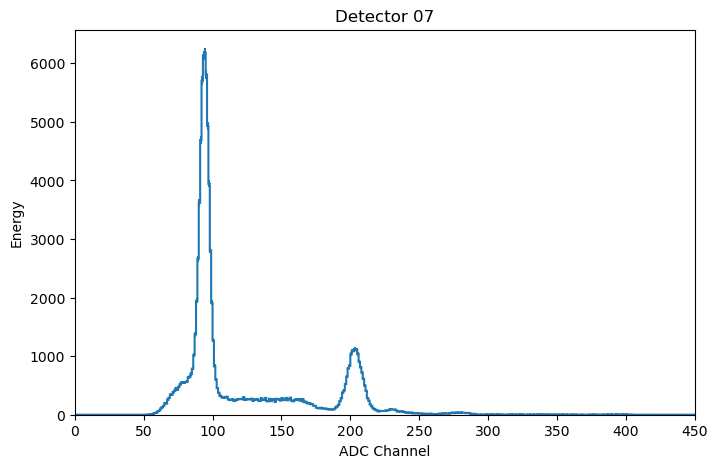

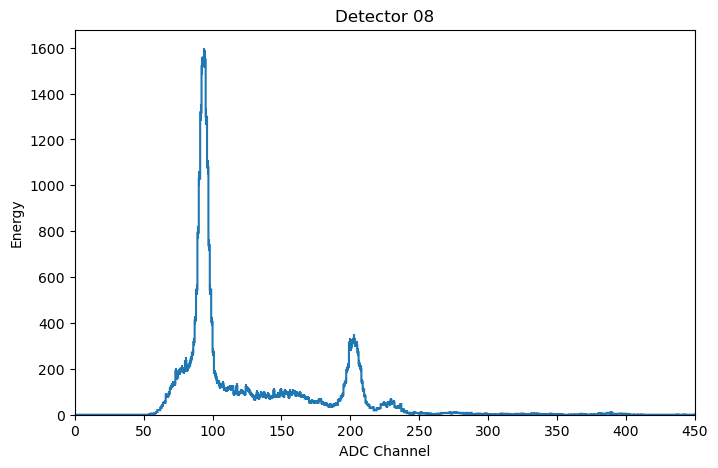

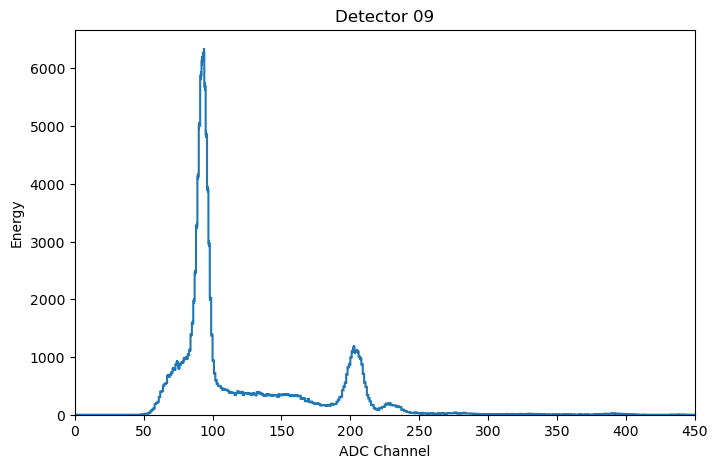

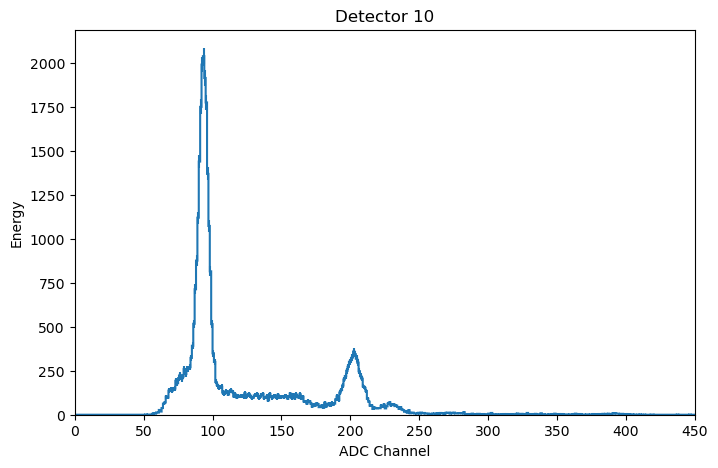

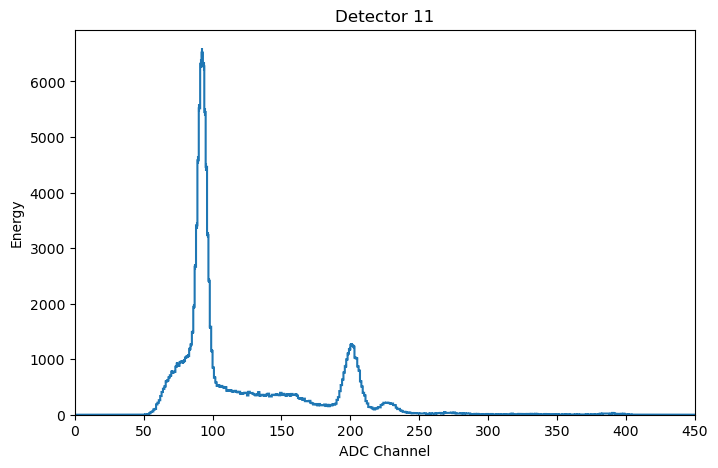

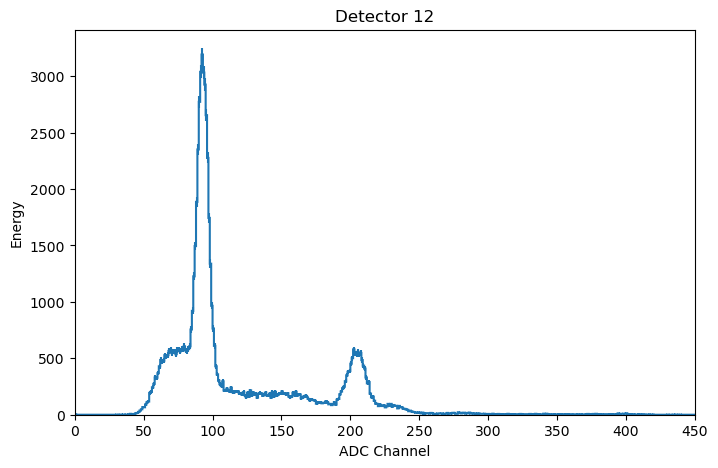

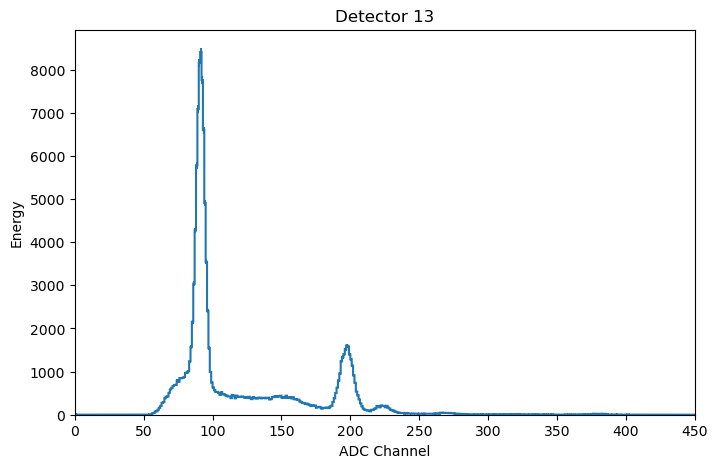

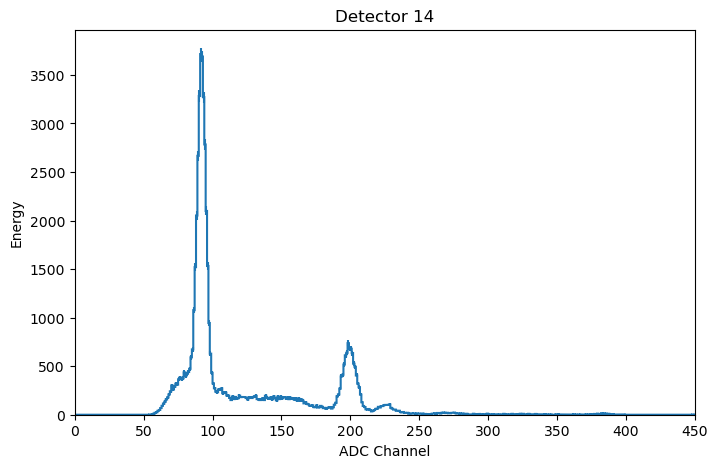

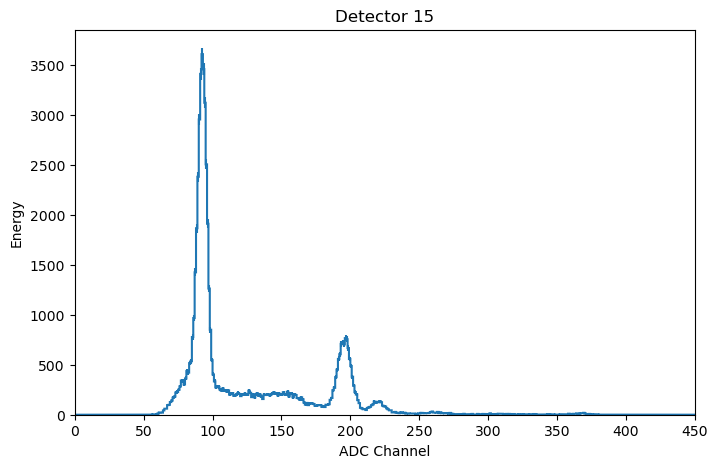

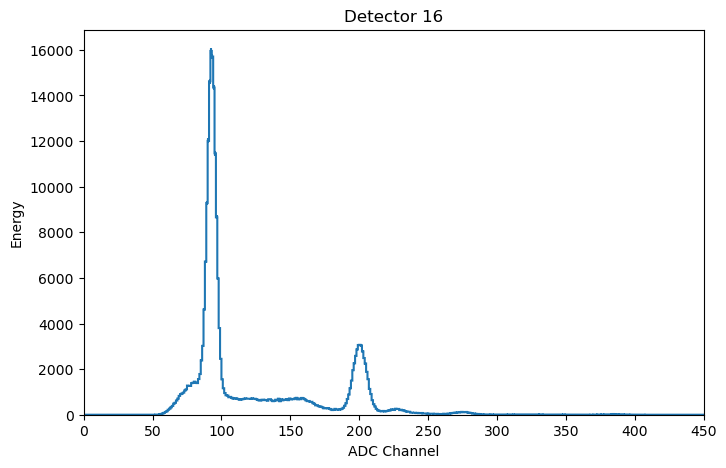

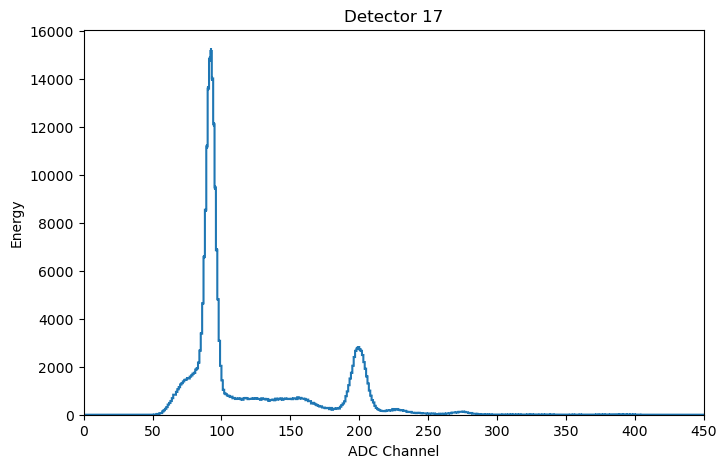

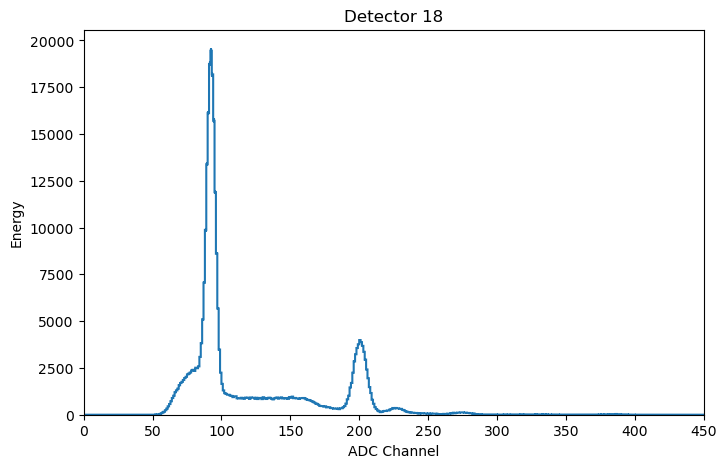

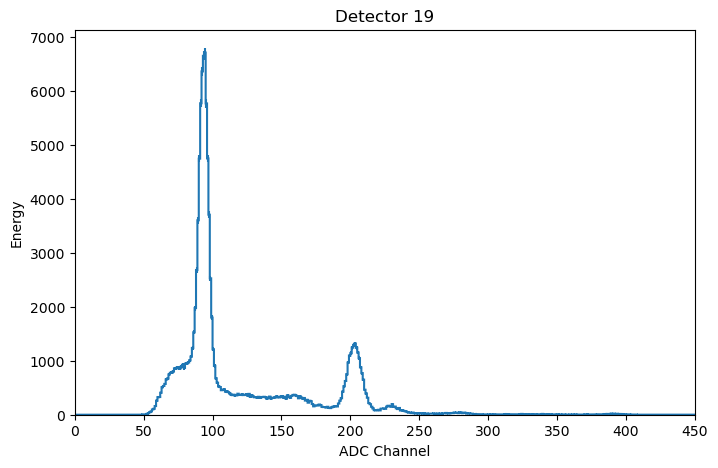

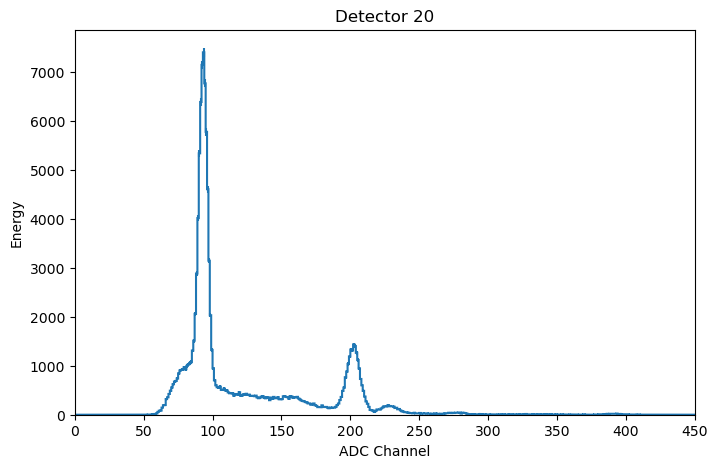

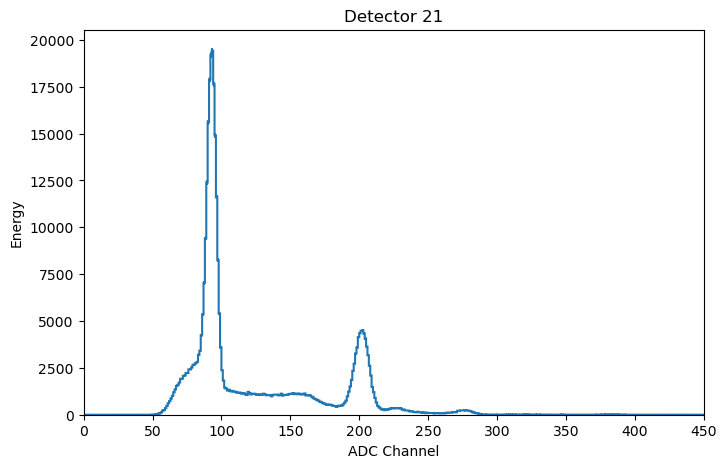

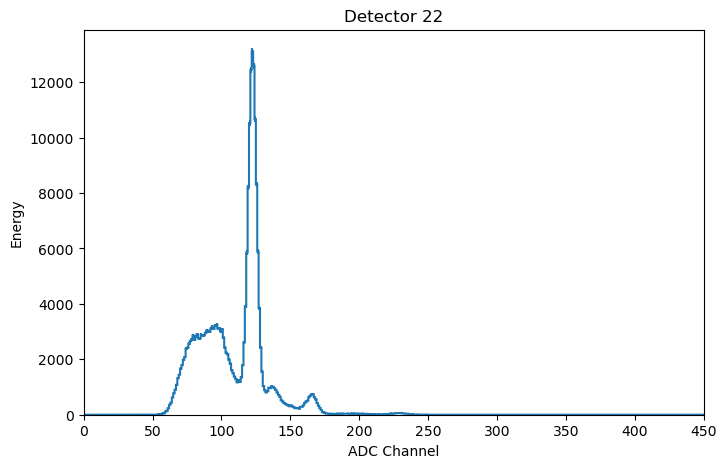

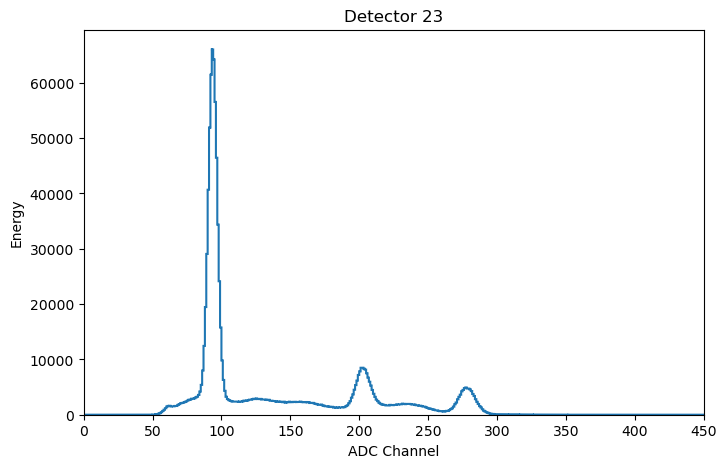

In [5]:
# Read in data from ROOT files and plot

directory = os.fsencode("Na22_Calibration")
    
for file in os.listdir(directory):
    
    filename = os.fsdecode(file)
    datafile = "Na22_Calibration/" + filename
    
    with uproot.open(datafile) as file:

        #print(file.keys())
        Na22 = file["Energy/_F_EnergyCH0@DT5751_626"]
        Na22Data = Na22.to_hist()
        
        PlotHist(filename,Na22Data)
        